## A/B-тестирование.

C:\Users\dimac\AppData\Local\Temp\ipykernel_24180\3623836743.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_pairs, x='Категория клиента', y='Доход (тыс руб.)', estimator=np.mean, ci=None)


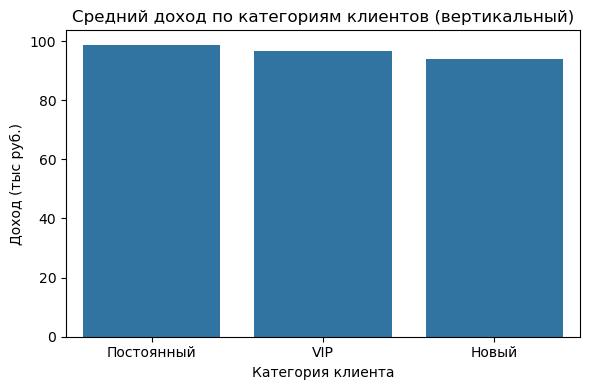

C:\Users\dimac\AppData\Local\Temp\ipykernel_24180\3623836743.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_pairs, y='Категория клиента', x='Доход (тыс руб.)', estimator=np.mean, ci=None)


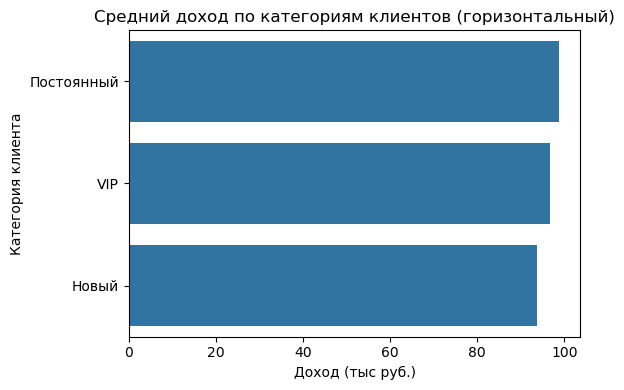

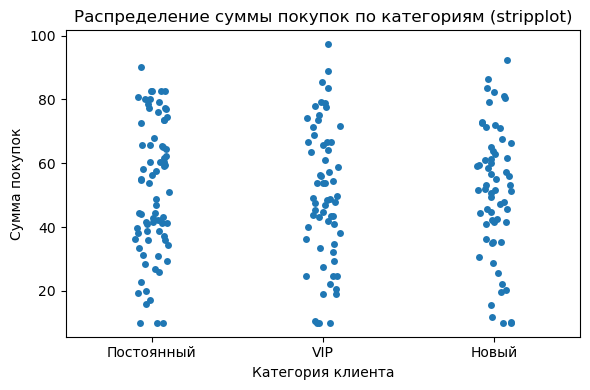

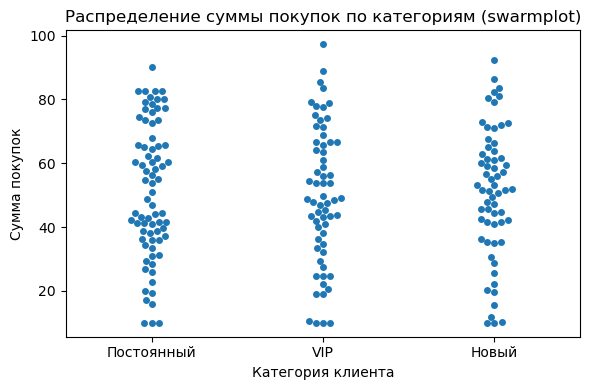

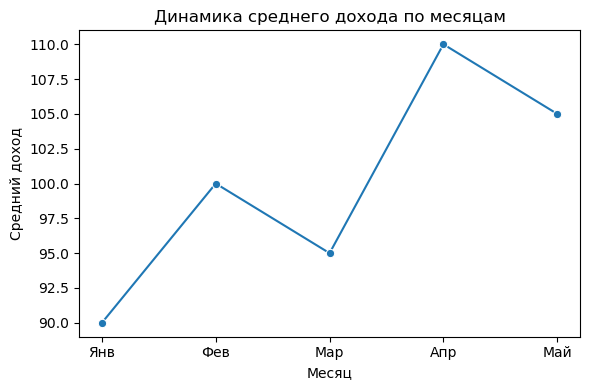

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Примерный датасет
np.random.seed(123)
n = 200
df_pairs = pd.DataFrame({
    'Возраст': np.random.normal(35, 10, size=n).clip(18, 65),
    'Доход (тыс руб.)': np.random.normal(100, 30, size=n).clip(30, 200),
    'Категория клиента': np.random.choice(['Новый', 'Постоянный', 'VIP'], size=n),
    'Сумма покупок': np.random.normal(50, 20, size=n).clip(10, 120)
})

# Вертикальный bar plot (средний доход по категориям)
plt.figure(figsize=(6, 4))
sns.barplot(data=df_pairs, x='Категория клиента', y='Доход (тыс руб.)', estimator=np.mean, ci=None)
plt.title('Средний доход по категориям клиентов (вертикальный)')
plt.ylabel('Доход (тыс руб.)')
plt.xlabel('Категория клиента')
plt.tight_layout()
plt.show()

# Горизонтальный bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=df_pairs, y='Категория клиента', x='Доход (тыс руб.)', estimator=np.mean, ci=None)
plt.title('Средний доход по категориям клиентов (горизонтальный)')
plt.xlabel('Доход (тыс руб.)')
plt.ylabel('Категория клиента')
plt.tight_layout()
plt.show()

# Strip plot
plt.figure(figsize=(6, 4))
sns.stripplot(data=df_pairs, x='Категория клиента', y='Сумма покупок', jitter=True)
plt.title('Распределение суммы покупок по категориям (stripplot)')
plt.tight_layout()
plt.show()

# Swarm plot
plt.figure(figsize=(6, 4))
sns.swarmplot(data=df_pairs, x='Категория клиента', y='Сумма покупок')
plt.title('Распределение суммы покупок по категориям (swarmplot)')
plt.tight_layout()
plt.show()

# Line plot (синтетические данные по месяцам)
df_line = pd.DataFrame({
    'Месяц': ['Янв', 'Фев', 'Мар', 'Апр', 'Май'],
    'Средний доход': [90, 100, 95, 110, 105]
})

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_line, x='Месяц', y='Средний доход', marker='o')
plt.title('Динамика среднего дохода по месяцам')
plt.tight_layout()
plt.show()


### 1. Описание задачи

Туристическая компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны предоставленные данные.

Бизнес-задача: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from statsmodels.stats import proportion
from scipy.stats import norm
from scipy.stats import t

import warnings
warnings.filterwarnings("ignore")

### 2. Загрузка и предобработка данных

In [3]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Данные представлены следующими полями:

- user_id — идентификатор пользователя, зашедшего на сайт;
- data — дата посещения сайта;
- group — группа теста (контрольная — А или тестовая — B);
- purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
- price — цена купленного тура (если покупка не состоялась, цена равна 0).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Пропусков в данных нет. Преобразуем дату к типу datetime и проверим длительность эксперимента для обеих групп.

In [5]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].describe()

,count,mean,min,25%,50%,75%,max
group,,,,,,,
A,147202,2021-01-13 01:55:49.470795520,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00
B,147276,2021-01-13 01:23:47.034955008,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00


Для обеих групп значение даты лежит в диапазоне от 13.01.2021 до 24.01.2021, то есть срок проведения и длительность A/B-тестирования для обеих групп совпадает.

Проверим, есть ли пользователи, попавшие в обе группы.

In [6]:
intersection_users = list(set(data[data['group'] == 'A']['user_id'].values) & \
set(data[data['group'] == 'B']['user_id'].values))
print('Кол-во пользователей, попавших в обе группы:', len(intersection_users))

Кол-во пользователей, попавших в обе группы: 1895


In [7]:
data[data['user_id'].isin(intersection_users)].shape

(3790, 5)

Удалим данные для пользоателей, попавших в обе группы.

In [8]:
intersection_rows = data[data['user_id'].isin(intersection_users)].index
data.drop(intersection_rows, inplace=True)
print('Удалили записей:', len(intersection_rows))
print('Осталось записей:', data.shape[0])

Удалили записей: 3790
Осталось записей: 290688


### 3. Первичный анализ результатов A/B-тестирования

In [9]:
grouped_data = data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename({'user_id': 'count_of_visits', 
           'purchase': 'count_of_purchases',
           'price': 'sum_of_purchases'}, axis=1)
grouped_data

,count_of_visits,count_of_purchases,sum_of_purchases
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Количество посещений в обеих группах примерно одинаково - можно говорить о сбалансированности выборок.

Рассчитаем показатели конверсии и среднего чека для каждой группы.

In [10]:
grouped_data['conversion'] = grouped_data['count_of_purchases'] / grouped_data['count_of_visits']
grouped_data['avg_bill'] = grouped_data['sum_of_purchases'] / grouped_data['count_of_purchases']
grouped_data

,count_of_visits,count_of_purchases,sum_of_purchases,conversion,avg_bill
group,,,,,
A,145307,17487,1417780000,0.120345,81076.228055
B,145381,17290,1533010000,0.118929,88664.545980


Значение коверсии выше в контрольной группе (А), при этом значение среднего чека выше в тестовой группе (В). Являются ли эти результаты статистически значимыми проверим в дальнейшем.

Рассчитаем кумулятивные показатели для анализа даных на предмет стабилизации метрик.

In [11]:
daily_data = data.groupby(['date','group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename({'user_id': 'count_of_visits', 
           'purchase': 'count_of_purchases',
           'price': 'sum_of_purchases'}, axis=1)
daily_data.head()

,date,group,count_of_visits,count_of_purchases,sum_of_purchases
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


In [12]:
daily_data['conversion'] = daily_data['count_of_purchases'] / daily_data['count_of_visits']
daily_data['avg_bill'] = daily_data['sum_of_purchases'] / daily_data['count_of_purchases']
daily_data.head()

,date,group,count_of_visits,count_of_purchases,sum_of_purchases,conversion,avg_bill
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270


In [13]:
daily_data['cum_count_of_visits'] = daily_data['count_of_visits'].cumsum()
daily_data['cum_count_of_purchases'] = daily_data['count_of_purchases'].cumsum()
daily_data['cum_sum_of_purchases'] = daily_data['sum_of_purchases'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_count_of_purchases'] / daily_data['cum_count_of_visits']
daily_data['cum_avg_bill'] = daily_data['cum_sum_of_purchases'] / daily_data['cum_count_of_purchases']
daily_data.head()

,date,group,count_of_visits,count_of_purchases,sum_of_purchases,conversion,avg_bill,cum_count_of_visits,cum_count_of_purchases,cum_sum_of_purchases,cum_conversion,cum_avg_bill
0,2021-01-02,A,2854,359,29410000,0.125788,81922.005571,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,0.120587,85971.014493,5715,704,59070000,0.123185,83906.250000
2,2021-01-03,A,6596,748,62000000,0.113402,82887.700535,12311,1452,121070000,0.117943,83381.542700
3,2021-01-03,B,6619,754,65960000,0.113914,87480.106101,18930,2206,187030000,0.116535,84782.411605
4,2021-01-04,A,6566,799,64250000,0.121687,80413.016270,25496,3005,251280000,0.117862,83620.632280


In [15]:
!pip install -U kaleido

   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/65.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/65.9 MB 825.8 kB/s eta 0:01:20
   ---------------------------------------- 0.1/65.9 MB 1.2 MB/s eta 0:00:54
   ---------------------------------------- 0.3/65.9 MB 1.9 MB/s eta 0:00:35
   ---------------------------------------- 0.6/65.9 MB 2.9 MB/s eta 0:00:23
    --------------------------------------- 1.1/65.9 MB 4.3 MB/s eta 0:00:15
    --------------------------------------- 1.6/65.9 MB 5.4 MB/s eta 0:00:12
   - -------------------------------------- 1.7/65.9 MB 5.7 MB/s eta 0:00:12
   - -------------------------------------- 2.2/65.9 MB 5.6 MB/s eta 0:00:12
   - -------------------------------------- 3.3/65.9 MB 7.5 MB/s eta 0:00:09
   -- ------------------------------------- 3.7/65.9 MB 7.7 MB/s eta 0:00:09
   -- ------------------------------------- 4.2/65.9 MB 7.9 MB/s eta 0:00:08
   -- -----

In [19]:
fig = px.line(
    daily_data, 
    x='date', 
    y='cum_conversion', 
    color='group',
    title='График кумулятивной конверсии по дням'
    )
fig.show('png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


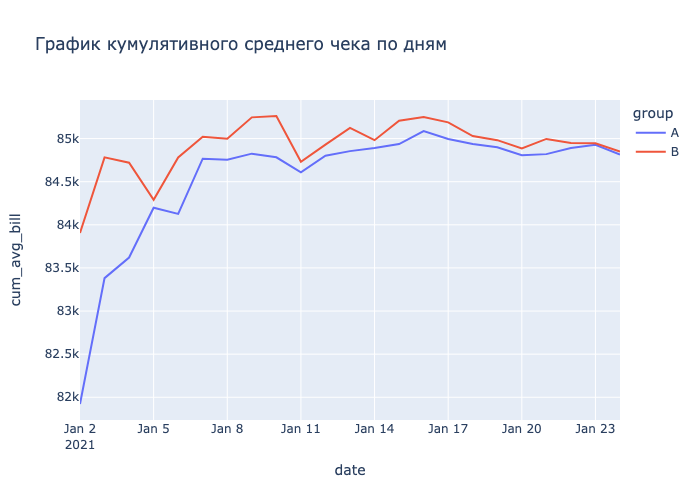

In [79]:
fig = px.line(
    daily_data, 
    x='date', 
    y='cum_avg_bill', 
    color='group',
    title='График кумулятивного среднего чека по дням'
    )
fig.show('png')

На графиках мы видим, что значения метрик стабилизировались во времени - A/B-тест можно назвать завершенным. При этом значения метрик практически равны в обеих группах.

### 4. Статистический анализ результатов  A/B-тестирования

#### 1. Статистический тест для конверсии.

Сформулируем следующие гипотезы:
- Нулевая: конверсии в группах А и В равны
$$ H_0 : p_a = p_b $$ 
- Альтернативная: конверсии в группах A и В  не равны
$$ H_1 : p_a \neq p_b $$ 

Будем использовать Z-тест для пропорций.

In [81]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=grouped_data['count_of_purchases'], #число «успехов»
    nobs=grouped_data['count_of_visits'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


При проведении теста p-value выше установленного уровня значимости, у нас нет оснований отвергнуть нулевую гипотезу, т.е. конверсии в группах A и В равны. 

#### 2. Статистический тест для ежедневного среднего чека.

Для начала построим гистограмму для ежедневного среднего чека.

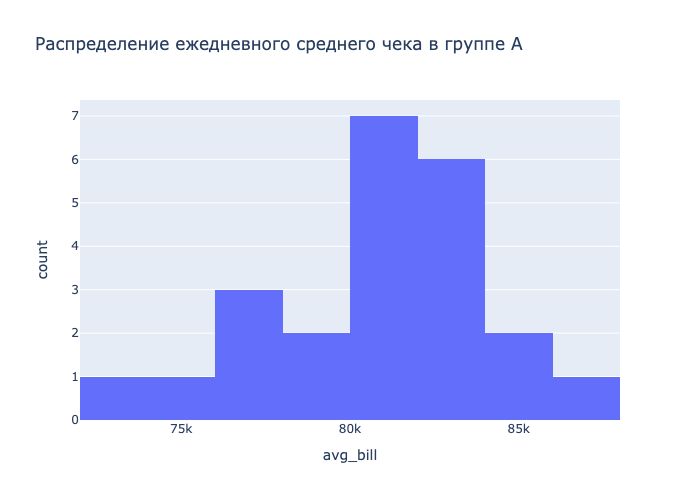

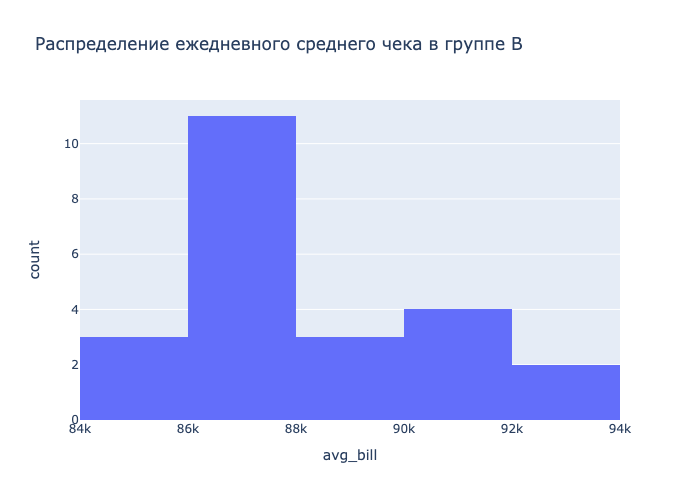

In [100]:
fig_a = px.histogram(
    daily_data[daily_data['group']=='A'], 
    x='avg_bill',
#     bins=100,
    title='Распределение ежедневного среднего чека в группе А'
)
fig_b = px.histogram(
    daily_data[daily_data['group']=='B'], 
    x='avg_bill',
    title='Распределение ежедневного среднего чека в группе B'
)
fig_a.show('png')
fig_b.show('png')

Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка.

Зададим уровень значимости 0.5 и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):

In [97]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_data[daily_data['group']=='A']['avg_bill'])
shapiro_result_b = shapiro(daily_data[daily_data['group']=='B']['avg_bill'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить значение ежедневного среднего чека в группах.

Сформулируем статистические гипотезы для T-теста:

- Нулевая гипотеза: значения среднего чека в группах А и B равны:
$$ H_0:\mu_a=\mu_b $$

- Альтернативная гипотеза: значения среднего чека в группах А и B не равны
$$ H_1:\mu_a \neq \mu_b $$


In [102]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group']=='A']['avg_bill'],
    b=daily_data[daily_data['group']=='B']['avg_bill'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, в результате проведения T-теста мы получили p-value = 0, что меньше, чем уровень значимости. Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной, то есть разница в значениях среднего чека в группах статистически значима.

Проверим дополнительно одностороннюю гипотезу, чтобы убедиться, что средний чек выше в тестовой группе (B).

Сформулируем статистические гипотезы следующим образом:

- Нулевая гипотеза: средний чек в группе А больше или равен среднему чеку в группе B:
$$ H_0:\mu_a \geq \mu_b $$

- Альтернативная гипотеза: средний чек в группе А меньше среднего чека в группе B:
$$ H_1:\mu_a < \mu_b $$

In [105]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data[daily_data['group']=='A']['avg_bill'],
    b=daily_data[daily_data['group']=='B']['avg_bill'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, мы убедились, что средний чек в группе B выше среднего чека в группе A с установленным уровнем значимости 0.05

#### 3. Доверительный интервал для конверсии

Вычислим доверитильный интревал для конверсии в каждой из групп.

In [112]:
# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=grouped_data.loc['A']['count_of_purchases'],
    nobs=grouped_data.loc['A']['count_of_visits'],
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=grouped_data.loc['B']['count_of_purchases'],
    nobs=grouped_data.loc['B']['count_of_visits'],
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


Мы видим, что доверительные интервалы для групп A и B имеют пересечение.

Для наглядности построим также доверительный интервал разницы конверсий.

In [114]:
# Функция для расчета доверительного интервала разницы конверсий в %
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

# размеры выборок групп А и B
n = [grouped_data.loc['A']['count_of_visits'], grouped_data.loc['B']['count_of_visits']]
# выборочная пропорция групп A и B
x_p = [grouped_data.loc['A']['conversion'], grouped_data.loc['B']['conversion']]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %. То есть разница в конверсии может быть как положительной, так и отрицательной. 

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

#### 4. Доверительный интервал для среднего чека в каждой из групп.

In [127]:
n_a = data[data['price'] != 0].groupby('group')['price'].count().loc['A']
n_b = data[data['price'] != 0].groupby('group')['price'].count().loc['B']
x_mean_a = data[data['price'] != 0].groupby('group')['price'].mean().loc['A']
x_mean_b = data[data['price'] != 0].groupby('group')['price'].mean().loc['B']
x_std_a = data[data['price'] != 0].groupby('group')['price'].std().loc['A']
x_std_b = data[data['price'] != 0].groupby('group')['price'].std().loc['B']

In [130]:
# строим доверительный интервал для среднего чека с уровнем надежность 0.95
gamma=0.95
lower_a, upper_a = t.interval(
    gamma, 
    df=n_a-1, 
    loc=x_mean_a, 
    scale=x_std_a/(n_a ** 0.5)
)

lower_b, upper_b = t.interval(
    gamma, 
    df=n_b-1, 
    loc=x_mean_b, 
    scale=x_std_b/(n_b ** 0.5)
)

print('Доверительный интервал для среднего чека в группе А: {}'.format((round(lower_a), round(upper_a))))
print('Доверительный интервал для среднего чека в группе В: {}'.format((round(lower_b), round(upper_b))))


Доверительный интервал для среднего чека в группе А: (80138, 82015)
Доверительный интервал для среднего чека в группе В: (87728, 89601)


Пересечения между доверительными интервалами для среднего чека в группе А и группе В нет, то есть мы еще раз подтверждаем полученный ранее вывод, что размер среднего чека в группе В выше среднего чека в группе А с уровнем надежности 95%.

### 5. Выводы

На основании проведенного выше анализа результатов А/В-тестирования, можно сделать следующий выводы:
- по метрики конверсии нет статистически значимой разницы между двумя вариантами посадочной страницы
- по метрики среднего чека более предпочтительным является второй вариант посадочной страницы, который был показан пользователям из группы В